# Import Necessary Libraries 

In [1]:
%matplotlib inline


import numpy as np

import xarray as xr

#import regionmask 

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy.ma as ma
import csv
#import netCDF4 as nc
import scipy
import pandas
from glob import glob
import pandas as pd

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

In [2]:
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script
type(WhGrYlRd)  # our custom colormap

matplotlib.colors.ListedColormap

In [3]:
# WILL USE THESE UNITS FOR CONVERSIONS LATER, INITIALIZE HERE
R=8.317 #J/(mol K)
MW=200.59 #molecular weight of hg in g/mol
ppt=1e-12 #current [Hg0] units is ex. .03 ppt, where ppt is 1e-12
stdpressure=101325 #pascals
stdtemp=273.15 #Kelvins

# Upload Data from GEOS Chem Runs

In [4]:
def fix_ds(ds):
    return ds.assign_coords({'LON':ds.LON, 'LAT':ds.LAT, 'ETAC':ds.ETAC, 'ETAE':ds.ETAE, 
                            'time':pd.to_datetime(ds.attrs['Start_Date'], format='%Y%m%d')}
                           ).expand_dims('time')

#open base files (with artisnal mining)
ds_base=xr.open_mfdataset('/net/fs03/d1/angot/postdoc/GMA_2018/my_runs/production_runs_2x2.5/BASE/netcdf_output/trac.2015*.nc',
                         preprocess=fix_ds, concat_dim=['time'], combine='by_coords')
ds_base14=xr.open_mfdataset('/net/fs03/d1/angot/postdoc/GMA_2018/my_runs/production_runs_2x2.5/BASE/netcdf_output/trac.2014*.nc',
                         preprocess=fix_ds, concat_dim=['time'], combine='by_coords')


# Extract emission sources

In [5]:
#get list of variable names and extract sources 
srce=[]#create list of sources 
for item in list(ds_base.keys()):
    #print(item[:7])
    if item[:7]=='HG-SRCE':
        srce.append(item)# add source variable names to source list
        print(item,"=> ",ds_base[item].attrs) #print out the long names of the different sources 
    

HG-SRCE__Hg0_an =>  {'long_name': 'Anthro elemental Hg', 'unit': 'kg'}
HG-SRCE__Hg0_aq =>  {'long_name': 'Ocean mass of elemental Hg', 'unit': 'kg'}
HG-SRCE__Hg0_oc =>  {'long_name': 'Ocean-emitted elemental Hg', 'unit': 'kg'}
HG-SRCE__Hg0_ln =>  {'long_name': 'Land re-emitted elemental Hg', 'unit': 'kg'}
HG-SRCE__Hg0_na =>  {'long_name': 'Natural land source', 'unit': 'kg'}
HG-SRCE__Hg2_an =>  {'long_name': 'Anthro divalent Hg', 'unit': 'kg'}
HG-SRCE__Hg2_aq =>  {'long_name': 'Ocean mass of divalent Hg', 'unit': 'kg'}
HG-SRCE__Hg2_sk =>  {'long_name': 'Mass of Hg2 sunk in ocean', 'unit': 'kg'}
HG-SRCE__HgP_an =>  {'long_name': 'Anthro particulate Hg', 'unit': 'kg'}
HG-SRCE__Hgaq_tot =>  {'long_name': 'Total oceanic mercury', 'unit': 'kg'}
HG-SRCE__HgP_aq =>  {'long_name': 'Ocean mass of particulate Hg', 'unit': 'kg'}
HG-SRCE__JorgC =>  {'long_name': 'Mass of orgC sunk in ocean', 'unit': 'kg'}
HG-SRCE__Hg_bb =>  {'long_name': 'Hg biomass burn emis', 'unit': 'kg'}
HG-SRCE__Hg_vg =>  {'l

## Create Dataset with sources only

In [6]:
ds_srce=xr.Dataset() # create empty source xarray 
for item in srce:
    ds_srce[item]=ds_base[item]# add sources from ds_base to source xarray
    

In [7]:
#create data frame with sources
df_srce = ds_srce.to_dataframe()
df_srce

LON   LAT  HG-SRCE__Hg0_an  \
Alt-000 Lat-000 Lon-000 time                                       
0       0       0       2015-01-01 -180.0 -89.5              0.0   
                        2015-02-01 -180.0 -89.5              0.0   
                        2015-03-01 -180.0 -89.5              0.0   
                        2015-04-01 -180.0 -89.5              0.0   
                        2015-05-01 -180.0 -89.5              0.0   
...                                   ...   ...              ...   
        90      143     2015-08-01  177.5  89.5              0.0   
                        2015-09-01  177.5  89.5              0.0   
                        2015-10-01  177.5  89.5              0.0   
                        2015-11-01  177.5  89.5              0.0   
                        2015-12-01  177.5  89.5              0.0   

                                    HG-SRCE__Hg0_aq  HG-SRCE__Hg0_oc  \
Alt-000 Lat-000 Lon-000 time                                           
0       0       0       2015-01-01              0.0              0.0   
                        2015-02-01              0.0              0.0   
                        2015-03-01              0.0              0.0   
                        2015-04-01              0.0              0.0   
                        2015-05-01              0.0              0.0   
...                                             ...              ...   
        90      143     2015-08-01              0.0              0.0   
                        2015-09-01              0.0              0.0   
                        2015-10-01              0.0              0.0   
                        2015-11-01              0.0              0.0   
                        2015-12-01              0.0              0.0   

                                    HG-SRCE__Hg0_ln  HG-SRCE__Hg0_na  \
Alt-000 Lat-000 Lon-000 time                                           
0       0       0       2015-01-01              0.0              0.0   
                        2015-02-01              0.0              0.0   
                        2015-03-01              0.0              0.0   
                        2015-04-01              0.0              0.0   
                        2015-05-01              0.0              0.0   
...                                             ...              ...   
        90      143     2015-08-01              0.0              0.0   
                        2015-09-01              0.0              0.0   
                        2015-10-01              0.0              0.0   
                        2015-11-01              0.0              0.0   
                        2015-12-01              0.0              0.0   

                                    HG-SRCE__Hg2_an  HG-SRCE__Hg2_aq  \
Alt-000 Lat-000 Lon-000 time                                           
0       0       0       2015-01-01              0.0              0.0   
                        2015-02-01              0.0              0.0   
                        2015-03-01              0.0              0.0   
                        2015-04-01              0.0              0.0   
                        2015-05-01              0.0              0.0   
...                                             ...              ...   
        90      143     2015-08-01              0.0              0.0   
                        2015-09-01              0.0              0.0   
                        2015-10-01              0.0              0.0   
                        2015-11-01              0.0              0.0   
                        2015-12-01              0.0              0.0   

                                    HG-SRCE__Hg2_sk  ...  HG-SRCE__Hg_bb  \
Alt-000 Lat-000 Lon-000 time                         ...                   
0       0       0       2015-01-01              0.0  ...             0.0   
                        2015-02-01              0.0  ...             0.0   
                        2015-03-01    

In [8]:
#find the total for each emissions source
totals=[]
names =[]
for item in srce:
    name=ds_srce[item].attrs.get("long_name")
    total = df_srce[item].sum()/1000
    names.append(name)
    totals.append(total)
dict(zip(names,totals)) 

{'Anthro elemental Hg': 1827.223375,
 'Ocean mass of elemental Hg': 0.0,
 'Ocean-emitted elemental Hg': 3266.7685,
 'Land re-emitted elemental Hg': 56.77196875,
 'Natural land source': 250.314703125,
 'Anthro divalent Hg': 399.2506875,
 'Ocean mass of divalent Hg': 0.0,
 'Mass of Hg2 sunk in ocean': 0.0,
 'Anthro particulate Hg': 0.0,
 'Total oceanic mercury': 0.0,
 'Ocean mass of particulate Hg': 0.0,
 'Mass of orgC sunk in ocean': 0.0,
 'Hg biomass burn emis': 252.71696875,
 'Hg vegetation emissions': 0.0,
 'Hg soil emissions': 776.6590625,
 'Hg ocean up flux': 0.0,
 'Hg ocean downflux': 0.0,
 'Snow emission of Hg': 49.378734375,
 'Snow Hg2 delivered to ocean': 0.0,
 'HgII/HgP dep to open ocean': 0.0,
 'HgII/HgP dep to snow/ice': 88.327234375,
 'Hg2 from rivers': 0.0}

In [9]:
#create dataframe of totals
df_emit = pd.DataFrame(list(dict(zip(names,totals)).items()),columns = ['Name','Total (t)'])
df_emit

,Name,Total (t)
0,Anthro elemental Hg,1827.223375
1,Ocean mass of elemental Hg,0.000000
2,Ocean-emitted elemental Hg,3266.768500
3,Land re-emitted elemental Hg,56.771969
4,Natural land source,250.314703
5,Anthro divalent Hg,399.250688
6,Ocean mass of divalent Hg,0.000000
7,Mass of Hg2 sunk in ocean,0.000000
8,Anthro particulate Hg,0.000000
9,Total oceanic mercury,0.000000


## Isolate the sources for Latin America

In [10]:
#Fix coordinates 
dr_srce = df_srce.to_xarray()
drop=dr_srce.drop('Lon-000')
new=dr_srce.drop('Lat-000')
dr_fsrce=new.assign_coords({'Lon-000':np.arange(-180., 180., 2.5), 'Lat-000':np.arange(-90., 90., 1.98)})
dr_fsrce

<xarray.Dataset>
Dimensions:            (Alt-000: 1, Lat-000: 91, Lon-000: 144, time: 12)
Coordinates:
  * Alt-000            (Alt-000) int64 0
  * Lon-000            (Lon-000) float64 -180.0 -177.5 -175.0 ... 175.0 177.5
  * time               (time) datetime64[ns] 2015-01-01 ... 2015-12-01
  * Lat-000            (Lat-000) float64 -90.0 -88.02 -86.04 ... 86.22 88.2
Data variables:
    LON                (Alt-000, Lat-000, Lon-000, time) float32 -180.0 ... 1...
    LAT                (Alt-000, Lat-000, Lon-000, time) float32 -89.5 ... 89.5
    HG-SRCE__Hg0_an    (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg0_aq    (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg0_oc    (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg0_ln    (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg0_na    (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg2_an    (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg2_aq    (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg2_sk    (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__HgP_an    (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hgaq_tot  (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__HgP_aq    (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__JorgC     (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg_bb     (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg_vg     (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg_so     (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg_up     (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg_down   (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hg0_snow  (Alt-000, Lat-000, Lon-000, time) float32 0.04537 ... 0.0
    HG-SRCE__Hg_sn_oc  (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hgdep_oc  (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0
    HG-SRCE__Hgdep_sn  (Alt-000, Lat-000, Lon-000, time) float32 0.1185 ... 0...
    HG-SRCE__Hg2_riv   (Alt-000, Lat-000, Lon-000, time) float32 0.0 0.0 ... 0.0

In [11]:
# change the coordinate names 
dr_fsrce=dr_fsrce.rename({'Lon-000': 'longitude','Lat-000': 'latitude'})# change the coordinate names 
dr_fsrce

<xarray.Dataset>
Dimensions:            (Alt-000: 1, latitude: 91, longitude: 144, time: 12)
Coordinates:
  * Alt-000            (Alt-000) int64 0
  * longitude          (longitude) float64 -180.0 -177.5 -175.0 ... 175.0 177.5
  * time               (time) datetime64[ns] 2015-01-01 ... 2015-12-01
  * latitude           (latitude) float64 -90.0 -88.02 -86.04 ... 86.22 88.2
Data variables:
    LON                (Alt-000, latitude, longitude, time) float32 -180.0 .....
    LAT                (Alt-000, latitude, longitude, time) float32 -89.5 ......
    HG-SRCE__Hg0_an    (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg0_aq    (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg0_oc    (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg0_ln    (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg0_na    (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg2_an    (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg2_aq    (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg2_sk    (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__HgP_an    (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hgaq_tot  (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__HgP_aq    (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__JorgC     (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg_bb     (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg_vg     (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg_so     (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg_up     (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg_down   (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hg0_snow  (Alt-000, latitude, longitude, time) float32 0.04537 ....
    HG-SRCE__Hg_sn_oc  (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hgdep_oc  (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0
    HG-SRCE__Hgdep_sn  (Alt-000, latitude, longitude, time) float32 0.1185 .....
    HG-SRCE__Hg2_riv   (Alt-000, latitude, longitude, time) float32 0.0 ... 0.0

In [12]:
Latam_srce=dr_fsrce.loc[dict(longitude=slice(-92.0,-25.0),latitude=slice(-58,18))]

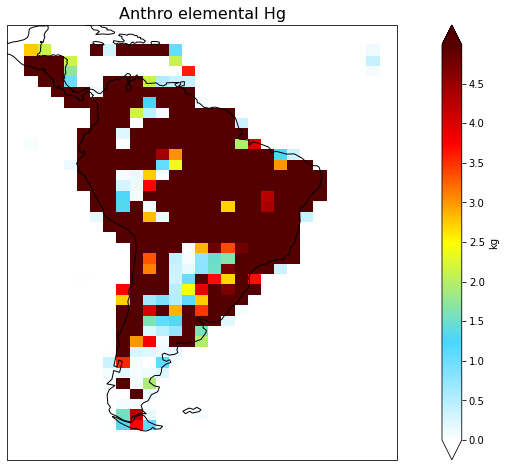

In [13]:
#ds_srce['HG-SRCE__Hg0_an'].mean(dim='time').plot()
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

Latam_srce['HG-SRCE__Hg0_an'].groupby('time.year').mean('time').plot(ax=ax, #set the axis
                        levels = np.arange(0, 5, .01), #set the levels for our colorbars
                       extend='both',#extend the colorbar in both directions
                       transform=ccrs.PlateCarree(), #fit data into map
                       cbar_kwargs={'label':ds_srce['HG-SRCE__Hg0_an'].attrs['unit']}, #label our colorbar (use ds_a just to get units)
                        cmap=WhGrYlRd)  #choose color for our colorbar

ax.coastlines() #add coastlines
plt.title(ds_srce['HG-SRCE__Hg0_an'].attrs['long_name'], fontsize = 16); #title
#av=df_d.resample('AS').mean()
#print('Global Average Value from Model: ',av['IJ-AVG-S_Hg0'][0])

In [14]:
#create shortened dataset for ds_base
ds_b=xr.Dataset()
ds_b['IJ-AVG-S_Hg0']=(ds_base['IJ-AVG-S__Hg0'])
ds_b['IJ-AVG-S_HgP']=(ds_base['IJ-AVG-S__HgP'])
ds_b['IJ-AVG-S_Hg2']=(ds_base['IJ-AVG-S__Hg2'])
ds_b['BXHGHT-S_BXHEIGHT']=(ds_base['BXHGHT-S__BXHEIGHT'])
ds_b['BXHGHT-S_T']=(ds_base['BXHGHT-S__T']) #Kelvins
ds_b['BXHGHT-S_PMID']=(ds_base['BXHGHT-S__PMID'])*100 #hpa to pa
ds_b['BXHGHT-S_PMID'].attrs['unit']='Pa'

df_base = ds_b.to_dataframe()
df_Bsurf=df_base[:157248]

# #######changing units to ng/m3 from ppt using P/(TR)*pptv*MW #########

'''P/(TR)*ppt*MW --> Pa/(K*J/(mol*K))*ppt*g/mol --> g/m3*ppt. to get rid of ppt, multiply by 1e-12.'''
species=['IJ-AVG-S_Hg0', 'IJ-AVG-S_HgP', 'IJ-AVG-S_Hg2']
for s in species:
    df_Bsurf[s]= df_Bsurf[s]*ppt* stdpressure/(stdtemp*R)*MW*1e9 #1e9 converts from g to ng

#now units are ng/m3
ds_b['IJ-AVG-S_Hg0'].attrs['unit']='ng/m3'
df_Bsurf

<ipython-input-14-045ecbc7d5c1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Bsurf[s]= df_Bsurf[s]*ppt* stdpressure/(stdtemp*R)*MW*1e9 #1e9 converts from g to ng


LON   LAT    ETAC  IJ-AVG-S_Hg0  \
Alt-002 Lat-000 Lon-000 time                                            
0       0       0       2015-01-01 -180.0 -89.5  0.9925      0.296195   
                        2015-02-01 -180.0 -89.5  0.9925      0.375870   
                        2015-03-01 -180.0 -89.5  0.9925      0.543671   
                        2015-04-01 -180.0 -89.5  0.9925      0.700514   
                        2015-05-01 -180.0 -89.5  0.9925      0.807922   
...                                   ...   ...     ...           ...   
        90      143     2015-08-01  177.5  89.5  0.9925      1.237127   
                        2015-09-01  177.5  89.5  0.9925      1.185414   
                        2015-10-01  177.5  89.5  0.9925      1.135955   
                        2015-11-01  177.5  89.5  0.9925      1.195990   
                        2015-12-01  177.5  89.5  0.9925      1.240376   

                                    IJ-AVG-S_HgP  IJ-AVG-S_Hg2  \
Alt-002 Lat-000 Lon-000 time                                     
0       0       0       2015-01-01      0.000755      0.193154   
                        2015-02-01      0.001226      0.172827   
                        2015-03-01      0.003294      0.091802   
                        2015-04-01      0.004061      0.030097   
                        2015-05-01      0.001511      0.014398   
...                                          ...           ...   
        90      143     2015-08-01      0.000054      0.016492   
                        2015-09-01      0.000050      0.009507   
                        2015-10-01      0.000061      0.006596   
                        2015-11-01      0.000098      0.006804   
                        2015-12-01      0.000576      0.010650   

                                    BXHGHT-S_BXHEIGHT  BXHGHT-S_T  \
Alt-002 Lat-000 Lon-000 time                                        
0       0       0       2015-01-01         107.518860  243.372177   
                        2015-02-01         103.024323  233.246002   
                        2015-03-01          98.928185  223.993530   
                        2015-04-01          97.008392  219.652405   
                        2015-05-01          95.623589  216.517517   
...                                               ...         ...   
        90      143     2015-08-01         120.496178  271.896362   
                        2015-09-01         117.139946  264.515991   
                        2015-10-01         114.769691  259.267059   
                        2015-11-01         111.021034  250.896500   
                        2015-12-01         109.221947  246.856720   

                                    BXHGHT-S_PMID  
Alt-002 Lat-000 Lon-000 time                       
0       0       0       2015-01-01   68390.937500  
                        2015-02-01   67798.328125  
                        2015-03-01   67384.945312  
                        2015-04-01   67216.367188  
                        2015-05-01   67350.507812  
...                                           ...  
        90      143     2015-08-01  101052.953125  
                        2015-09-01   99916.156250  
                        2015-10-01  100093.390625  
                        2015-11-01   99812.796875  
                        2015-12-01  100425.359375  

[157248 rows x 9 columns]

In [16]:
#create shortened dataset for ds_base
ds_b14=xr.Dataset()
ds_b14['IJ-AVG-S_Hg0']=(ds_base14['IJ-AVG-S__Hg0'])
ds_b14['IJ-AVG-S_HgP']=(ds_base14['IJ-AVG-S__HgP'])
ds_b14['IJ-AVG-S_Hg2']=(ds_base14['IJ-AVG-S__Hg2'])
ds_b14['BXHGHT-S_BXHEIGHT']=(ds_base14['BXHGHT-S__BXHEIGHT'])
ds_b14['BXHGHT-S_T']=(ds_base14['BXHGHT-S__T']) #Kelvins
ds_b14['BXHGHT-S_PMID']=(ds_base14['BXHGHT-S__PMID'])*100 #hpa to pa
ds_b14['BXHGHT-S_PMID'].attrs['unit']='Pa'

df_base14 = ds_b14.to_dataframe()
df_Bsurf14=df_base14[:157248]


# #######changing units to ng/m3 from ppt using P/(TR)*pptv*MW #########

'''P/(TR)*ppt*MW --> Pa/(K*J/(mol*K))*ppt*g/mol --> g/m3*ppt. to get rid of ppt, multiply by 1e-12.'''
species=['IJ-AVG-S_Hg0', 'IJ-AVG-S_HgP', 'IJ-AVG-S_Hg2']
for s in species:
    #df_Bsurf14[s]= df_Bsurf14[s]*ppt* stdpressure/(stdtemp*R)*MW*1e9 #1e9 converts from g to ng
    df_Bsurf14[s]= df_Bsurf14[s]*ppt* df_Bsurf14['BXHGHT-S_PMID']/(df_Bsurf14['BXHGHT-S_T']*R)*MW*1e9 #1e9 converts from g to ng

#now units are ng/m3
ds_b14['IJ-AVG-S_Hg0'].attrs['unit']='ng/m3'
df_Bsurf14

<ipython-input-16-1309803d96c2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Bsurf14[s]= df_Bsurf14[s]*ppt* df_Bsurf14['BXHGHT-S_PMID']/(df_Bsurf14['BXHGHT-S_T']*R)*MW*1e9 #1e9 converts from g to ng


LON   LAT    ETAC  IJ-AVG-S_Hg0  \
Alt-002 Lat-000 Lon-000 time                                            
0       0       0       2014-01-01 -180.0 -89.5  0.9925      0.175108   
                        2014-02-01 -180.0 -89.5  0.9925      0.216624   
                        2014-03-01 -180.0 -89.5  0.9925      0.361509   
                        2014-04-01 -180.0 -89.5  0.9925      0.541023   
                        2014-05-01 -180.0 -89.5  0.9925      0.634596   
...                                   ...   ...     ...           ...   
        90      143     2014-08-01  177.5  89.5  0.9925      1.242952   
                        2014-09-01  177.5  89.5  0.9925      1.190722   
                        2014-10-01  177.5  89.5  0.9925      1.205071   
                        2014-11-01  177.5  89.5  0.9925      1.291072   
                        2014-12-01  177.5  89.5  0.9925      1.376316   

                                    IJ-AVG-S_HgP  IJ-AVG-S_Hg2  \
Alt-002 Lat-000 Lon-000 time                                     
0       0       0       2014-01-01      0.000424      0.122525   
                        2014-02-01      0.000997      0.100545   
                        2014-03-01      0.002210      0.071961   
                        2014-04-01      0.001515      0.023650   
                        2014-05-01      0.000229      0.012450   
...                                          ...           ...   
        90      143     2014-08-01      0.000032      0.008277   
                        2014-09-01      0.000039      0.008454   
                        2014-10-01      0.000056      0.008970   
                        2014-11-01      0.000255      0.010717   
                        2014-12-01      0.000097      0.010113   

                                    BXHGHT-S_BXHEIGHT  BXHGHT-S_T  \
Alt-002 Lat-000 Lon-000 time                                        
0       0       0       2014-01-01         108.010864  244.470261   
                        2014-02-01         102.535950  232.141724   
                        2014-03-01          98.248817  222.456436   
                        2014-04-01          97.165726  220.004440   
                        2014-05-01          97.774414  221.370682   
...                                               ...         ...   
        90      143     2014-08-01         120.250351  271.330505   
                        2014-09-01         117.934242  266.272034   
                        2014-10-01         114.610291  258.904022   
                        2014-11-01         111.129082  251.132751   
                        2014-12-01         111.206718  251.294662   

                                    BXHGHT-S_PMID  
Alt-002 Lat-000 Lon-000 time                       
0       0       0       2014-01-01   68688.062500  
                        2014-02-01   67905.710938  
                        2014-03-01   67472.476562  
                        2014-04-01   67412.640625  
                        2014-05-01   68188.554688  
...                                           ...  
        90      143     2014-08-01  100288.476562  
                        2014-09-01   99864.476562  
                        2014-10-01  101388.304688  
                        2014-11-01  100375.554688  
                        2014-12-01  100824.734375  

[157248 rows x 9 columns]

In [17]:
df_Bsurf14['IJ-AVG-S_Hg0']

Alt-002  Lat-000  Lon-000  time      
0        0        0        2014-01-01    0.175108
                           2014-02-01    0.216624
                           2014-03-01    0.361509
                           2014-04-01    0.541023
                           2014-05-01    0.634596
                                           ...   
         90       143      2014-08-01    1.242952
                           2014-09-01    1.190722
                           2014-10-01    1.205071
                           2014-11-01    1.291072
                           2014-12-01    1.376316
Name: IJ-AVG-S_Hg0, Length: 157248, dtype: float32

## Change Modified data set to xarray

In [18]:
dr=df_Bsurf14['IJ-AVG-S_Hg0'].to_xarray()
dr

<xarray.DataArray 'IJ-AVG-S_Hg0' (Alt-002: 1, Lat-000: 91, Lon-000: 144, time: 12)>
array([[[[0.1751082 , 0.21662356, 0.36150873, ..., 0.642791  ,
          0.37322116, 0.24913244],
         [0.1751082 , 0.21662356, 0.36150855, ..., 0.642791  ,
          0.3732212 , 0.24913247],
         [0.1751082 , 0.21662356, 0.36150855, ..., 0.642791  ,
          0.3732212 , 0.24913247],
         ...,
         [0.1751082 , 0.21662356, 0.36150894, ..., 0.6427909 ,
          0.37322107, 0.24913235],
         [0.1751082 , 0.21662356, 0.36150855, ..., 0.642791  ,
          0.3732212 , 0.24913247],
         [0.1751082 , 0.21662356, 0.36150855, ..., 0.642791  ,
          0.3732212 , 0.24913247]],

        [[0.17540106, 0.21470682, 0.3490786 , ..., 0.6257841 ,
          0.3702467 , 0.24986832],
         [0.17531343, 0.21453913, 0.34881836, ..., 0.6250693 ,
          0.36998346, 0.24975953],
         [0.17519474, 0.21435235, 0.34854195, ..., 0.6243213 ,
          0.36968532, 0.24960497],
...
         [1.4769235 , 1.5124153 , 1.4499958 , ..., 1.2078203 ,
          1.2828666 , 1.3715365 ],
         [1.4769392 , 1.5127765 , 1.4508811 , ..., 1.2081221 ,
          1.2831405 , 1.3720313 ],
         [1.4769319 , 1.5131375 , 1.4517658 , ..., 1.2084279 ,
          1.2834182 , 1.3725816 ]],

        [[1.4621346 , 1.5086762 , 1.4448224 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ],
         [1.4621346 , 1.5086762 , 1.4448224 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ],
         [1.4621346 , 1.5086762 , 1.4448224 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ],
         ...,
         [1.4621346 , 1.5086762 , 1.4448223 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ],
         [1.4621346 , 1.5086762 , 1.4448224 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ],
         [1.4621346 , 1.5086762 , 1.4448224 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ]]]], dtype=float32)
Coordinates:
  * Alt-002  (Alt-002) int64 0
  * Lat-000  (Lat-000) int64 0 1 2 3 4 5 6 7 8 9 ... 82 83 84 85 86 87 88 89 90
  * Lon-000  (Lon-000) int64 0 1 2 3 4 5 6 7 ... 136 137 138 139 140 141 142 143
  * time     (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2014-12-01

In [19]:
#coordinates got messed up so fix it

drop=dr.drop('Lon-000')
new=dr.drop('Lat-000')
dr_fixed=new.assign_coords({'Lon-000':np.arange(-180., 180., 2.5), 'Lat-000':np.arange(-90., 90., 1.98)})
dr_fixed

<xarray.DataArray 'IJ-AVG-S_Hg0' (Alt-002: 1, Lat-000: 91, Lon-000: 144, time: 12)>
array([[[[0.1751082 , 0.21662356, 0.36150873, ..., 0.642791  ,
          0.37322116, 0.24913244],
         [0.1751082 , 0.21662356, 0.36150855, ..., 0.642791  ,
          0.3732212 , 0.24913247],
         [0.1751082 , 0.21662356, 0.36150855, ..., 0.642791  ,
          0.3732212 , 0.24913247],
         ...,
         [0.1751082 , 0.21662356, 0.36150894, ..., 0.6427909 ,
          0.37322107, 0.24913235],
         [0.1751082 , 0.21662356, 0.36150855, ..., 0.642791  ,
          0.3732212 , 0.24913247],
         [0.1751082 , 0.21662356, 0.36150855, ..., 0.642791  ,
          0.3732212 , 0.24913247]],

        [[0.17540106, 0.21470682, 0.3490786 , ..., 0.6257841 ,
          0.3702467 , 0.24986832],
         [0.17531343, 0.21453913, 0.34881836, ..., 0.6250693 ,
          0.36998346, 0.24975953],
         [0.17519474, 0.21435235, 0.34854195, ..., 0.6243213 ,
          0.36968532, 0.24960497],
...
         [1.4769235 , 1.5124153 , 1.4499958 , ..., 1.2078203 ,
          1.2828666 , 1.3715365 ],
         [1.4769392 , 1.5127765 , 1.4508811 , ..., 1.2081221 ,
          1.2831405 , 1.3720313 ],
         [1.4769319 , 1.5131375 , 1.4517658 , ..., 1.2084279 ,
          1.2834182 , 1.3725816 ]],

        [[1.4621346 , 1.5086762 , 1.4448224 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ],
         [1.4621346 , 1.5086762 , 1.4448224 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ],
         [1.4621346 , 1.5086762 , 1.4448224 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ],
         ...,
         [1.4621346 , 1.5086762 , 1.4448223 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ],
         [1.4621346 , 1.5086762 , 1.4448224 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ],
         [1.4621346 , 1.5086762 , 1.4448224 , ..., 1.2050706 ,
          1.2910724 , 1.3763158 ]]]], dtype=float32)
Coordinates:
  * Alt-002  (Alt-002) int64 0
  * Lon-000  (Lon-000) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2014-12-01
  * Lat-000  (Lat-000) float64 -90.0 -88.02 -86.04 -84.06 ... 84.24 86.22 88.2

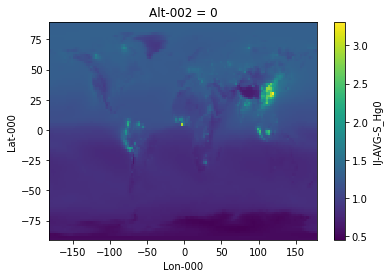

In [20]:
dr_fixed.mean(dim='time').plot() #test plot

## Plot Hg0 Annual Average concentration for the entire globe

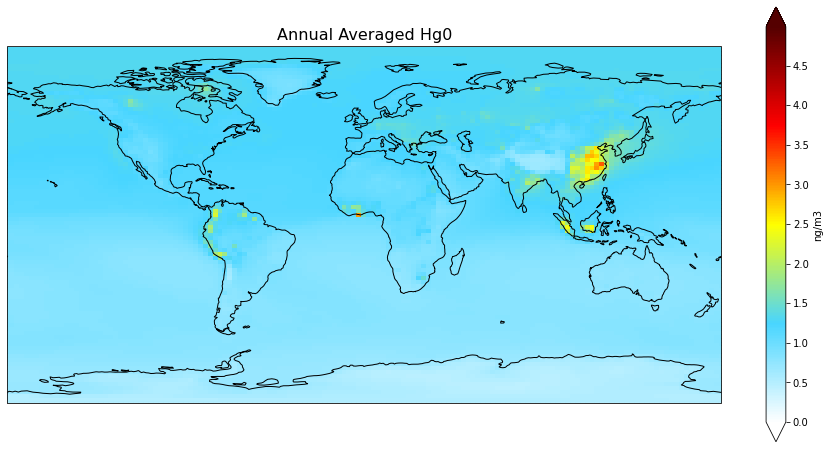

In [21]:
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

dr_fixed.groupby('time.year').mean('time').plot(ax=ax, #set the axis
                        levels = np.arange(0, 5, .01), #set the levels for our colorbars
                       extend='both',#extend the colorbar in both directions
                       transform=ccrs.PlateCarree(), #fit data into map
                       cbar_kwargs={'label':ds_b['IJ-AVG-S_Hg0'].attrs['unit']}, #label our colorbar (use ds_a just to get units)
                        cmap=WhGrYlRd)  #choose color for our colorbar

ax.coastlines() #add coastlines
plt.title('Annual Averaged Hg0', fontsize = 16); #title
#av=df_d.resample('AS').mean()
#print('Global Average Value from Model: ',av['IJ-AVG-S_Hg0'][0])

# Plot Hg0  Annual Average concentration for the entire globe with standard Temp and Pressure

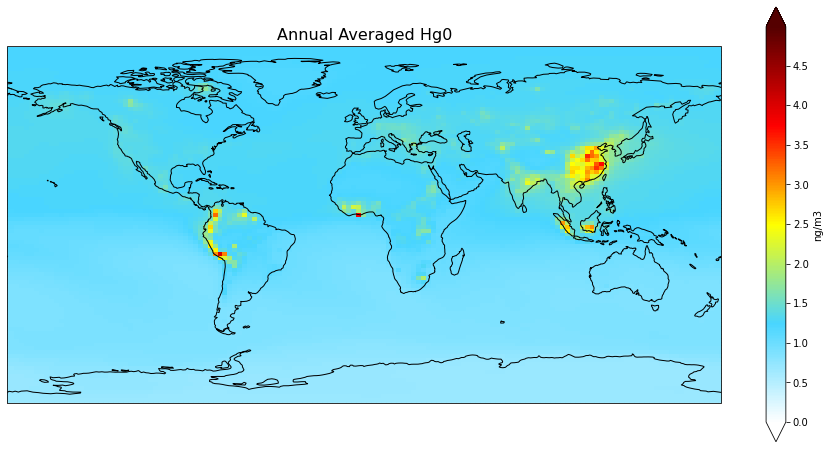

In [33]:
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

dr_fixed.groupby('time.year').mean('time').plot(ax=ax, #set the axis
                        levels = np.arange(0, 5, .01), #set the levels for our colorbars
                       extend='both',#extend the colorbar in both directions
                       transform=ccrs.PlateCarree(), #fit data into map
                       cbar_kwargs={'label':ds_b['IJ-AVG-S_Hg0'].attrs['unit']}, #label our colorbar (use ds_a just to get units)
                        cmap=WhGrYlRd)  #choose color for our colorbar

ax.coastlines() #add coastlines
plt.title('Annual Averaged Hg0', fontsize = 16); #title
#av=df_d.resample('AS').mean()
#print('Global Average Value from Model: ',av['IJ-AVG-S_Hg0'][0])

In [26]:
dr_yearX=dr_fixed.groupby('time.year').mean('time') # create a array of annual averages 
dr_yearX

<xarray.DataArray 'IJ-AVG-S_Hg0' (Alt-002: 1, Lat-000: 91, Lon-000: 144, year: 1)>
array([[[[0.52662426],
         [0.52662426],
         [0.52662426],
         ...,
         [0.52662426],
         [0.52662426],
         [0.52662426]],

        [[0.51162285],
         [0.5110334 ],
         [0.5104439 ],
         ...,
         [0.5137586 ],
         [0.5130078 ],
         [0.5122741 ]],

        [[0.5060211 ],
         [0.5114039 ],
         [0.50996333],
         ...,
...
         ...,
         [1.3121814 ],
         [1.3126702 ],
         [1.3131855 ]],

        [[1.308361  ],
         [1.3086245 ],
         [1.3088814 ],
         ...,
         [1.307607  ],
         [1.3078549 ],
         [1.3081053 ]],

        [[1.3063555 ],
         [1.3063555 ],
         [1.3063555 ],
         ...,
         [1.3063555 ],
         [1.3063555 ],
         [1.3063555 ]]]], dtype=float32)
Coordinates:
  * Alt-002  (Alt-002) int64 0
  * Lon-000  (Lon-000) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * Lat-000  (Lat-000) float64 -90.0 -88.02 -86.04 -84.06 ... 84.24 86.22 88.2
  * year     (year) int64 2014

In [27]:
dr_yearX=dr_yearX.rename({'Lon-000': 'longitude','Lat-000': 'latitude'})# change the coordinate names 
dr_yearX

<xarray.DataArray 'IJ-AVG-S_Hg0' (Alt-002: 1, latitude: 91, longitude: 144, year: 1)>
array([[[[0.52662426],
         [0.52662426],
         [0.52662426],
         ...,
         [0.52662426],
         [0.52662426],
         [0.52662426]],

        [[0.51162285],
         [0.5110334 ],
         [0.5104439 ],
         ...,
         [0.5137586 ],
         [0.5130078 ],
         [0.5122741 ]],

        [[0.5060211 ],
         [0.5114039 ],
         [0.50996333],
         ...,
...
         ...,
         [1.3121814 ],
         [1.3126702 ],
         [1.3131855 ]],

        [[1.308361  ],
         [1.3086245 ],
         [1.3088814 ],
         ...,
         [1.307607  ],
         [1.3078549 ],
         [1.3081053 ]],

        [[1.3063555 ],
         [1.3063555 ],
         [1.3063555 ],
         ...,
         [1.3063555 ],
         [1.3063555 ],
         [1.3063555 ]]]], dtype=float32)
Coordinates:
  * Alt-002    (Alt-002) int64 0
  * longitude  (longitude) float64 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * latitude   (latitude) float64 -90.0 -88.02 -86.04 ... 84.24 86.22 88.2
  * year       (year) int64 2014

# Isolate annual Averages for South America

In [28]:
LAPA=dr_yearX.loc[dict(longitude=slice(-92.0,-25.0),latitude=slice(-58,18))]# isolate data for South America 
#da.loc[dict(time=slice("2000-01-01", "2000-01-02"))]

In [29]:
LAPA

<xarray.DataArray 'IJ-AVG-S_Hg0' (Alt-002: 1, latitude: 38, longitude: 27, year: 1)>
array([[[[0.8173681 ],
         [0.8158607 ],
         [0.8156664 ],
         ...,
         [0.80658007],
         [0.80659467],
         [0.80292493]],

        [[0.82285434],
         [0.82300895],
         [0.8245655 ],
         ...,
         [0.8211555 ],
         [0.81577605],
         [0.8108267 ]],

        [[0.8315633 ],
         [0.8323254 ],
         [0.83388954],
         ...,
...
         ...,
         [1.1761501 ],
         [1.1779137 ],
         [1.1792067 ]],

        [[1.1580714 ],
         [1.1783706 ],
         [1.1733236 ],
         ...,
         [1.1792411 ],
         [1.1829581 ],
         [1.1847602 ]],

        [[1.1398329 ],
         [1.1698588 ],
         [1.1733807 ],
         ...,
         [1.1798931 ],
         [1.1856126 ],
         [1.190166  ]]]], dtype=float32)
Coordinates:
  * Alt-002    (Alt-002) int64 0
  * longitude  (longitude) float64 -90.0 -87.5 -85.0 -82.5 ... -30.0 -27.5 -25.0
  * latitude   (latitude) float64 -56.34 -54.36 -52.38 ... 12.96 14.94 16.92
  * year       (year) int64 2014

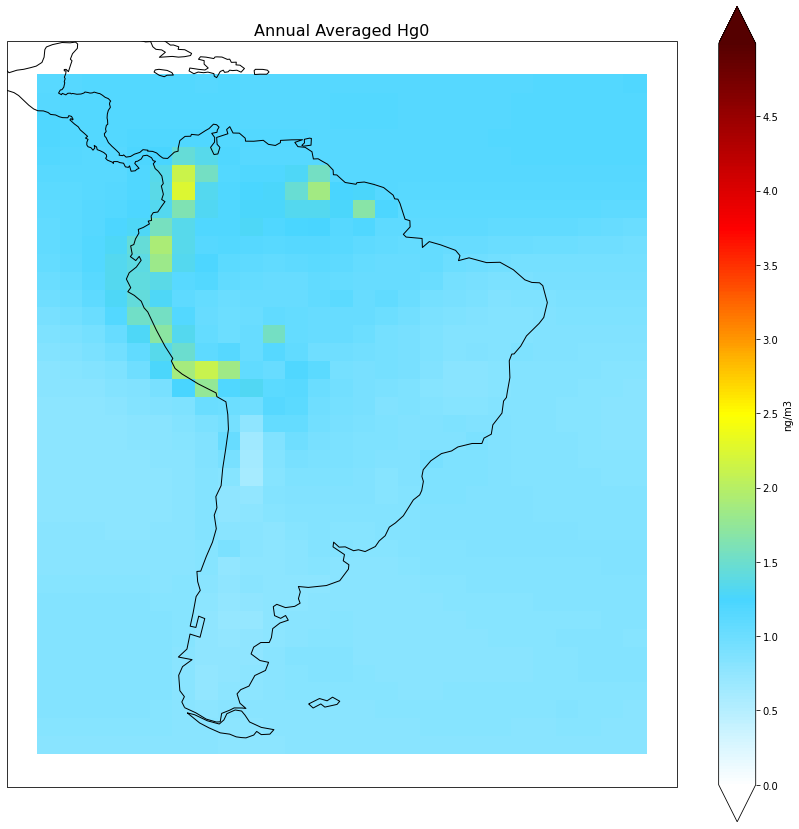

In [30]:
#Create plot for South America 
fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

LAPA.plot(ax=ax, #set the axis
                        levels = np.arange(0, 5, .01), #set the levels for our colorbars
                       extend='both',#extend the colorbar in both directions
                       transform=ccrs.PlateCarree(), #fit data into map
                       cbar_kwargs={'label':ds_b['IJ-AVG-S_Hg0'].attrs['unit']}, #label our colorbar (use ds_a just to get units)
                        cmap=WhGrYlRd)  #choose color for our colorbar

ax.coastlines() #add coastlines
#-92ax.set_extent([-150, -20, -90, 90])
plt.title('Annual Averaged Hg0', fontsize = 16); #title
#av=df_d.resample('AS').mean()
#print('Global Average Value from Model: ',av['IJ-AVG-S_Hg0'][0])

## Upload Data from Passive Samplers 

In [31]:
#import needed modules to plot data
import geoplot.crs as gcrs
import regionmask 
import geopandas as gpd
import geoplot as gplt
Lapan= pd.read_csv('Lapan.csv')
# Creating GeoPandas GeoDataFrame using the Pandas Dataframe 
Lapan_gdf = gpd.GeoDataFrame(Lapan, geometry = gpd.points_from_xy(Lapan['Longitude'],Lapan['Latitude'] ))



In [32]:
Lapan_gdf=Lapan_gdf.sort_values('Latitude') #sort the data from passive samplers by latitude 
Lapan_gdf

,Site,Latitude,Longitude,Date of deployment,Date of removal,Deployment length (days),Measured Conc (ng/m3),geometry
15,Glacie Dawin (Schapiarelli),-54.414400,-70.915700,2019-04-20,"March 14, 2020",329,0.79,POINT (-70.91570 -54.41440)
25,Villa Regina,-39.102333,-67.108361,2018-05-05,2019-05-01 00:00:00,361,0.79,POINT (-67.10836 -39.10233)
26,Bahia Blanca (after),-38.699528,-62.444778,2018-05-04,2019-04-30 00:00:00,361,0.95,POINT (-62.44478 -38.69953)
5,"Rio Grande, RS",-32.068906,-52.161475,2018-02-01,2019-01-31 00:00:00,364,1,POINT (-52.16148 -32.06891)
14,"Rio Grande, RS (Praça Tamandaré)",-32.033583,-52.099300,2018-12-29,2019-12-16 00:00:00,352,0.95,POINT (-52.09930 -32.03358)
1,"São José dos Ausentes, RS",-28.596650,-49.813100,2017-11-16,2018-11-20 00:00:00,369,0.63,POINT (-49.81310 -28.59665)
0,"Iguaçu National Park, PR",-25.626736,-54.478653,2017-10-20,2018-11-09 00:00:00,385,0.63,POINT (-54.47865 -25.62674)
27,Salta,-24.721342,-65.406064,2018-12-15,"January 6, 2020",387,0.99,POINT (-65.40606 -24.72134)
12,"Pico do Jaraguá, SP",-23.456314,-46.766117,2018-07-20,2019-07-31 00:00:00,376,1.22,POINT (-46.76612 -23.45631)
7,"Itatiaia National Park, RJ",-22.385833,-44.678889,2018-03-27,2019-07-02 00:00:00,462,0.8,POINT (-44.67889 -22.38583)


# Select Concentrations from the raw data

In [33]:
LAP=pd.DataFrame()
LAP['LONG']=Lapan_gdf['Longitude']
LAP['LATI']=Lapan_gdf['Latitude']
LAP['OBS']=Lapan_gdf['Measured Conc (ng/m3)']
LAP =LAP.reset_index(drop=True)


In [34]:
LAP =LAP.reset_index(drop=True)
LAP['OBS'].iloc[20]=0.59 # Choose the concentration recorded at 5m at Manaus becasue theese sould be surface concentrations
#The observations are currently recorded as strings. They need to be changed to floating point numbers
observe=[]
for item in LAP['OBS']:
    observe.append(float(item))
observe    
LAP['OBS']=observe

/home/tzd/anaconda3/envs/UniToro/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [35]:
print("Minimum concentration is ",LAP.OBS.min())
print("Maximum concentration is ",LAP.OBS.max())

Minimum concentration is  0.33
Maximum concentration is  6.87


## Change the coordinates to geodataframe 

In [36]:
 df_Latin = gpd.GeoDataFrame(LAP , geometry = gpd.points_from_xy(LAP['LONG'],LAP['LATI'] ))

In [42]:
df_Latin
L_OB_GEO =df_Latin.drop(columns=['LATI','LONG']) 
L_OB_GEO

,OBS,geometry
0,0.79,POINT (-70.91570 -54.41440)
1,0.79,POINT (-67.10836 -39.10233)
2,0.95,POINT (-62.44478 -38.69953)
3,1.00,POINT (-52.16148 -32.06891)
4,0.95,POINT (-52.09930 -32.03358)
5,0.63,POINT (-49.81310 -28.59665)
6,0.63,POINT (-54.47865 -25.62674)
7,0.99,POINT (-65.40606 -24.72134)
8,1.22,POINT (-46.76612 -23.45631)
9,0.80,POINT (-44.67889 -22.38583)


In [45]:
L_OB_GEO=L_OB_GEO.drop([26])

# Create Plot of Annual Average with the Observations 

/home/tzd/anaconda3/envs/UniToro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/tzd/anaconda3/envs/UniToro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/tzd/anaconda3/envs/UniToro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


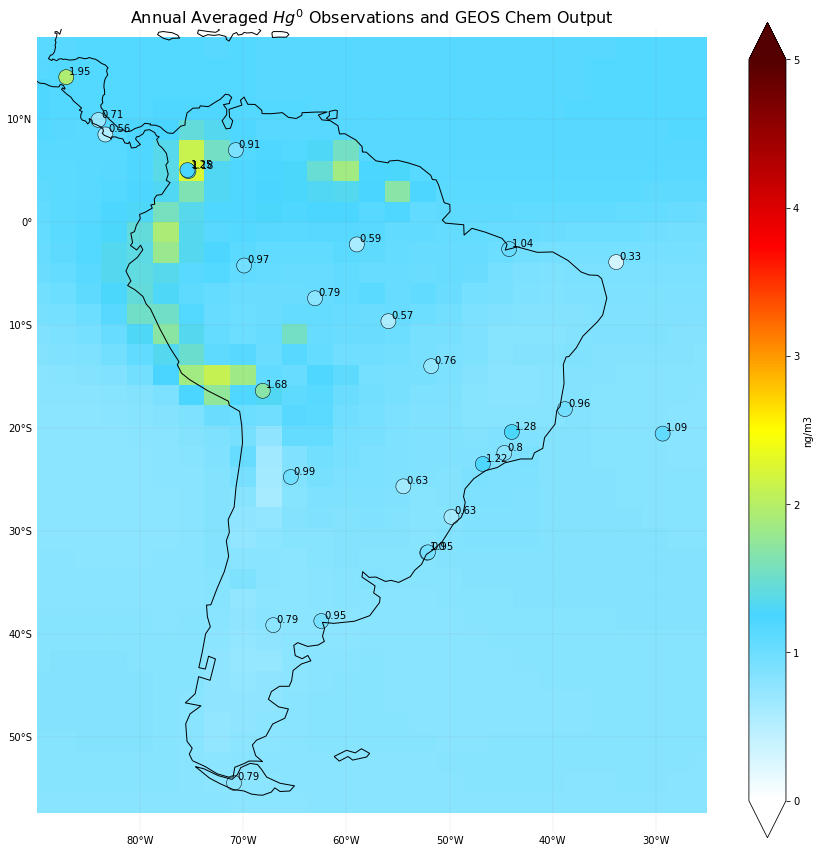

In [62]:
import matplotlib as mpl
fig = plt.figure(figsize=[15,15], frameon=True)
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=True)
norm = mpl.colors.Normalize(vmin=0, vmax=5)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=WhGrYlRd).cmap

LAPA.plot(ax=ax, #set the axis
                        #levels = np.arange(0, 5, .01), #set the levels for our colorbars
                       extend='both',#extend the colorbar in both directions
                       transform=ccrs.PlateCarree(), #fit data into map
                       cbar_kwargs={'label':ds_b['IJ-AVG-S_Hg0'].attrs['unit']}, #label our colorbar (use ds_a just to get units)
                        cmap=cmap,norm=norm)  #choose color for our colorbar
#L_OB_GEO.plot(ax=ax,marker='o',levels = np.arange(0, 5, .01),cmap='hsv', markersize=20,)
gplt.pointplot(L_OB_GEO,hue='OBS', cmap=cmap,norm=norm,ax=ax,edgecolor='black', linewidth=0.5,s = 15
)
for x, y, label in zip(L_OB_GEO.geometry.x, L_OB_GEO.geometry.y, L_OB_GEO.OBS):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
        
ax.coastlines() #add coastlines

#ax.outline_patch.set_edgecolor('black')
#ax.gridlines(linestyle='--')
ax.set_extent([-90, -25, -55, 16])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
plt.title('Annual Averaged $Hg^0$ Observations and GEOS Chem Output', fontsize = 16); #title
#av=df_d.resample('AS').mean()
#print('Global Average Value from Model: ',av['IJ-AVG-S_Hg0'][0])

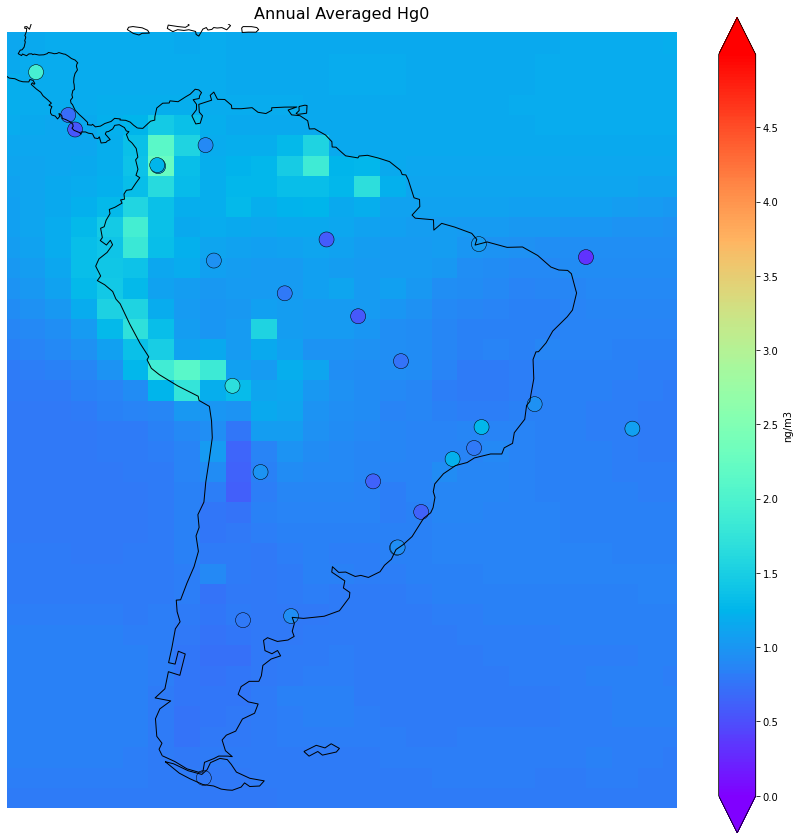

In [50]:
#longitude=slice(-92.0,-25.0),latitude=slice(-58,18))]

fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

LAPA.plot(ax=ax, #set the axis
                        levels = np.arange(0, 5, .01), #set the levels for our colorbars
                       extend='both',#extend the colorbar in both directions
                       transform=ccrs.PlateCarree(), #fit data into map
                       cbar_kwargs={'label':ds_b['IJ-AVG-S_Hg0'].attrs['unit']}, #label our colorbar (use ds_a just to get units)
                        cmap='rainbow')  #choose color for our colorbar
gplt.pointplot(L_OB_GEO,hue='OBS', cmap='rainbow', norm=norm,ax=ax,edgecolor='black', linewidth=0.5,s = 15
)
#for x, y, label in zip(L_OB_GEO.geometry.x, L_OB_GEO.geometry.y, L_OB_GEO.OBS):
      #  ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")


ax.set_extent([-90, -25, -55, 16])
ax.coastlines() #add coastlines
#-92ax.set_extent([-150, -20, -90, 90])
plt.title('Annual Averaged Hg0', fontsize = 16); #title
#av=df_d.resample('AS').mean()
#print('Global Average Value from Model: ',av['IJ-AVG-S_Hg0'][0])

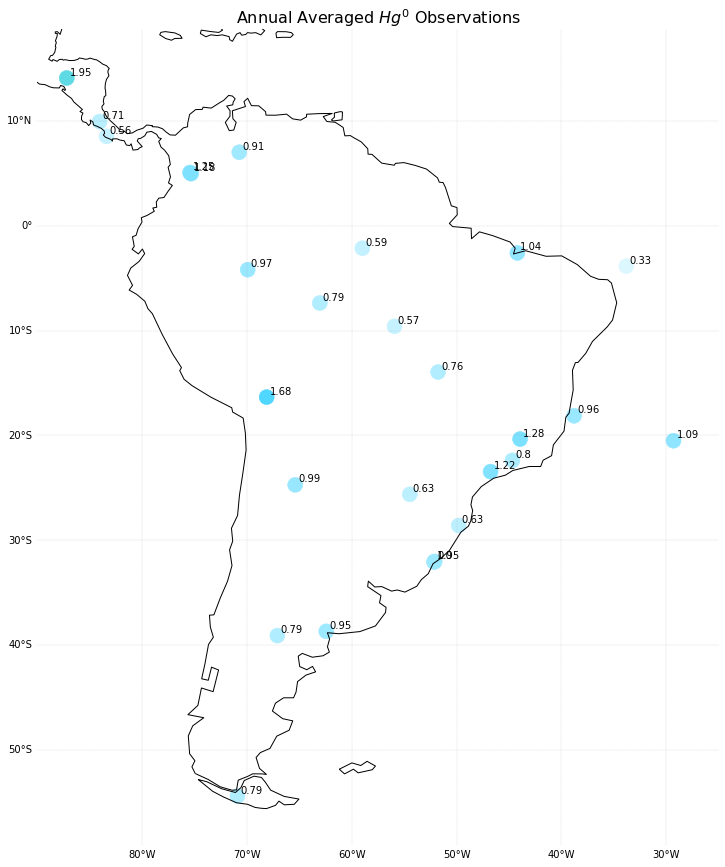

In [63]:
import matplotlib as mpl
fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
norm = mpl.colors.Normalize(vmin=0, vmax=7)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=WhGrYlRd).cmap

#LAPA.plot(ax=ax, #set the axis
                        #levels = np.arange(0, 5, .01), #set the levels for our colorbars
                       #extend='both',#extend the colorbar in both directions
                       #transform=ccrs.PlateCarree(), #fit data into map
                       #cbar_kwargs={'label':ds_a['IJ-AVG-S_Hg0'].attrs['unit']}, #label our colorbar (use ds_a just to get units)
                       # cmap=cmap,norm=norm)  #choose color for our colorbar
#L_OB_GEO.plot(ax=ax,marker='o',levels = np.arange(0, 5, .01),cmap='hsv', markersize=20,)
gplt.pointplot(L_OB_GEO,hue='OBS', cmap=WhGrYlRd,norm=norm,ax=ax,linewidth=0.5,s = 15,
               label='$Hg^0_{obs}$',legend=False)
for x, y, label in zip(L_OB_GEO.geometry.x, L_OB_GEO.geometry.y, L_OB_GEO.OBS):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
        
ax.coastlines() #add coastlines

ax.set_extent([-90, -25, -55, 16])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
plt.title('Annual Averaged $Hg^0$ Observations', fontsize = 16); #title
#av=df_d.resample('AS').mean()
#print('Global Average Value from Model: ',av['IJ-AVG-S_Hg0'][0])

In [52]:
LAP_GC=LAPA.sel(latitude=LAP['LATI'][1], longitude=LAP['LONG'][1],method="nearest")

In [53]:
My_list=[LAP_GC]
My_list[0].to_dataframe().reset_index(drop=True)['IJ-AVG-S_Hg0'][0]

0.8097165

In [54]:
GC_list=[]
for index,item in enumerate(LAP['OBS']):
    LAP_GC=LAPA.sel(latitude=LAP['LATI'][index], longitude=LAP['LONG'][index],method="nearest")
    val=LAP_GC.to_dataframe().reset_index(drop=True)['IJ-AVG-S_Hg0'][0]
    GC_list.append(val)
    print(item,':',val)

0.79 : 0.7910566
0.79 : 0.8097165
0.95 : 0.79377216
1.0 : 0.8348724
0.95 : 0.8348724
0.63 : 0.835553
0.63 : 0.88089967
0.99 : 0.8438116
1.22 : 0.86076665
0.8 : 0.86482626
1.09 : 0.8220124
1.28 : 0.8701632
0.96 : 0.8366372
1.68 : 1.3156775
0.76 : 0.93576044
0.57 : 1.0418307
0.79 : 1.0443345
0.97 : 1.0827495
0.33 : 0.94343424
1.04 : 1.0023826
0.59 : 1.1192539
1.18 : 2.2455466
1.25 : 2.2455466
0.91 : 1.1825463
0.56 : 1.1641846
0.71 : 1.1471123
6.87 : 1.1789073
1.95 : 1.1783706


In [55]:
df_comp=LAP
df_comp['GChem']=GC_list
df_comp

,LONG,LATI,OBS,geometry,GChem
0,-70.915700,-54.414400,0.79,POINT (-70.91570 -54.41440),0.791057
1,-67.108361,-39.102333,0.79,POINT (-67.10836 -39.10233),0.809717
2,-62.444778,-38.699528,0.95,POINT (-62.44478 -38.69953),0.793772
3,-52.161475,-32.068906,1.00,POINT (-52.16148 -32.06891),0.834872
4,-52.099300,-32.033583,0.95,POINT (-52.09930 -32.03358),0.834872
5,-49.813100,-28.596650,0.63,POINT (-49.81310 -28.59665),0.835553
6,-54.478653,-25.626736,0.63,POINT (-54.47865 -25.62674),0.880900
7,-65.406064,-24.721342,0.99,POINT (-65.40606 -24.72134),0.843812
8,-46.766117,-23.456314,1.22,POINT (-46.76612 -23.45631),0.860767
9,-44.678889,-22.385833,0.80,POINT (-44.67889 -22.38583),0.864826


'print("slope:", slope,\n      "\nintercept:", intercept,\n      "\nr squared:", r_value**2,\n      "\np-value:", p_value,\n      "\nst_error", std_err,\n      "\nRMSE", sqrt(std_err))'

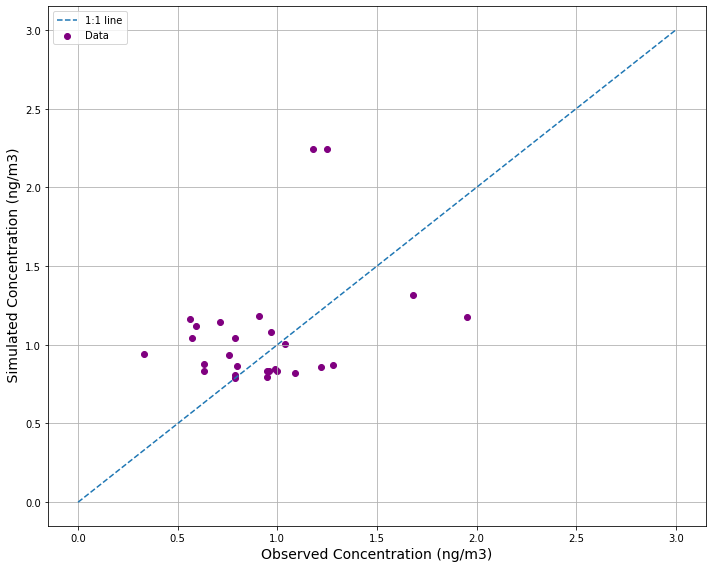

In [56]:
from math import *
import numpy as np
from scipy import stats

x = df_comp['OBS'].drop(index=26)
y=df_comp['GChem'].drop(index=26)
slope, intercept, r_value, p_value, std_err= stats.linregress(x, y)
m = slope.astype(float)
#Create a basic scatter plot with Matplotlib
#A identity line was created based on the minumum and maximum observed value
#Points markers are colored by the residual and a residual colorbar is added to the figure
#df_compare['Residual'] = df_compare['GChem']- df_compare['Hg0_M_C(ng/m3)']
fig = plt.figure(figsize=(10,8))
z = np.linspace(0,3.0, 100)
plt.plot(z, z, linestyle='dashed',label="1:1 line")
plt.scatter(x,y, marker='o',color="purple",label="Data")
#plt.plot(x, m*x + intercept, 'grey', label='regression fitted line')

#cbar = plt.colorbar()
#cbar.set_label('Residual (ng/m3)', fontsize=14)

plt.grid()
plt.legend()
plt.xlabel('Observed Concentration (ng/m3)', fontsize=14)
plt.ylabel(' Simulated Concentration (ng/m3)', fontsize=14)
fig.tight_layout()
#fig.savefig('../Figures/ObservedSimulatedHeadComparisonPlot.png')
"""print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))"""

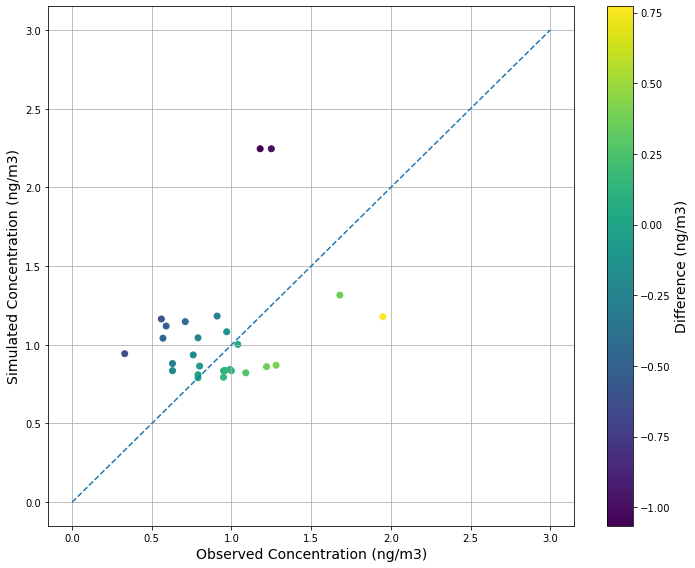

In [57]:
#Create a basic scatter plot with Matplotlib
#A identity line was created based on the minumum and maximum observed value
#Points markers are colored by the residual and a residual colorbar is added to the figure
df_new=df_comp.drop(index=26)
x = df_comp['OBS'].drop(index=26)
y=df_comp['GChem'].drop(index=26)
df_new['Residual'] = x-y
fig = plt.figure(figsize=(10,8))
w= np.linspace(0,3, 100)
plt.plot(w, w, linestyle='dashed')
plt.scatter(x,y, marker='o', c=df_new['Residual'])

cbar = plt.colorbar()
cbar.set_label('Difference (ng/m3)', fontsize=14)

plt.grid()
plt.xlabel('Observed Concentration (ng/m3)', fontsize=14)
plt.ylabel('Simulated Concentration (ng/m3)', fontsize=14)
fig.tight_layout()
#fig.savefig('../Figures/ObservedSimulatedHeadComparisonPlot.png')

In [58]:
#grap the latitude values from the data set to use for the x axes
Latitude =[]
for item in df_comp['LATI'].drop(index=26):
    Latitude.append(round(item, 2))


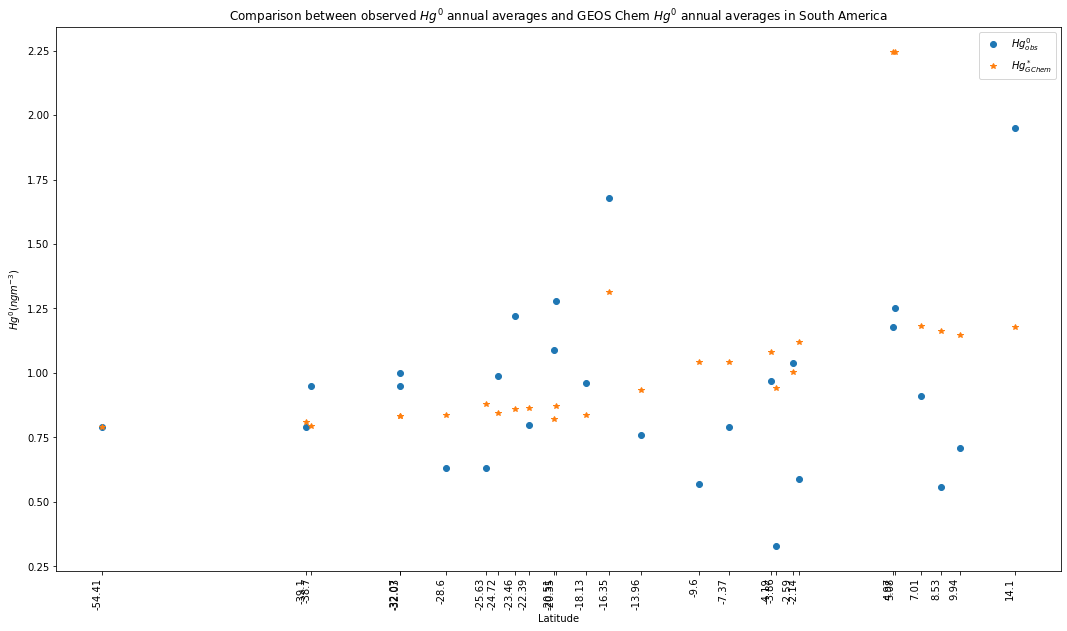

In [59]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
labels = Latitude
Hg0obs = df_comp['OBS'].drop(index=26)
Hg0_GC = df_comp['GChem'].drop(index=26)

x = Latitude  # the label locations


fig, ax = plt.subplots(figsize=[18,10])
rects1 = ax.plot(x,Hg0obs,'o', label='$Hg^0_{obs}$')
rects2 = ax.plot(x,Hg0_GC,'*', label='$Hg^*_{GChem}$')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$Hg^0 (ngm^{-3})$')
ax.set_title('Comparison between observed $Hg^0$ annual averages and GEOS Chem $Hg^0$ annual averages in South America ')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=10,ha='right')
#plt.xticks(x, labels, rotation='vertical')
#ax.legend()
ax.set_xlabel('Latitude')
legend_without_duplicate_labels(ax)

plt.show()

In [60]:
ticks=[x for x in np.arange(-55.0,20.0,5)]
ticks

[-55.0,
 -50.0,
 -45.0,
 -40.0,
 -35.0,
 -30.0,
 -25.0,
 -20.0,
 -15.0,
 -10.0,
 -5.0,
 0.0,
 5.0,
 10.0,
 15.0]

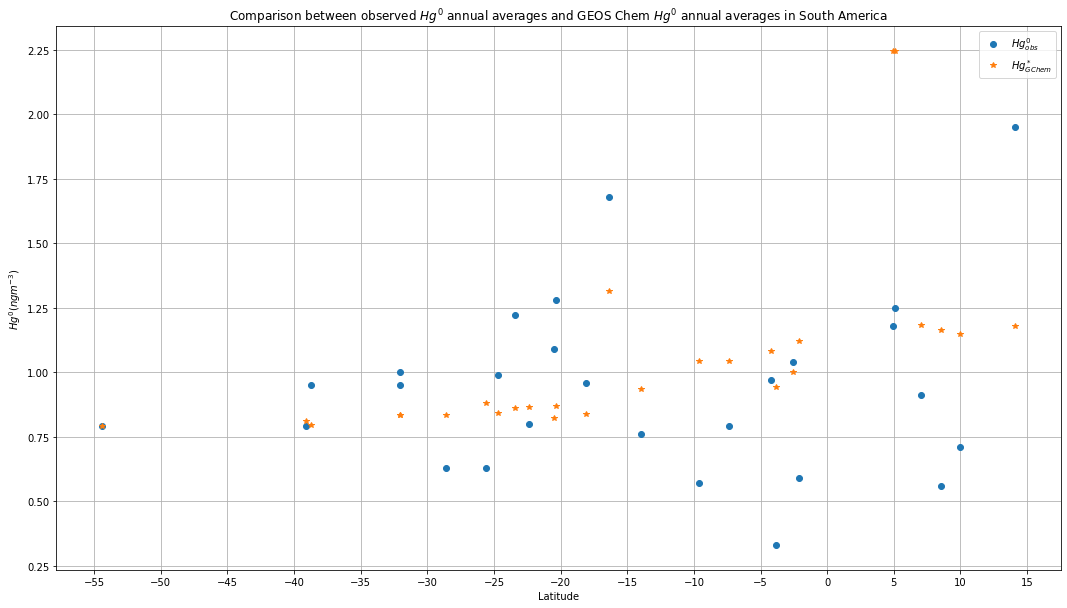

In [61]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
labels = Latitude
Hg0obs = df_comp['OBS'].drop(index=26)
Hg0_GC = df_comp['GChem'].drop(index=26)

x = Latitude  # the label locations


fig, ax = plt.subplots(figsize=[18,10])
rects1 = ax.plot(x,Hg0obs,'o', label='$Hg^0_{obs}$')
rects2 = ax.plot(x,Hg0_GC,'*', label='$Hg^*_{GChem}$')
#rects3 = ax.plot(x,np.full((len(x)), Hg0_GC.min()),'--', label='Minimum GEOS Chem Output')
ax.grid()

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$Hg^0 (ngm^{-3})$')
ax.set_title('Comparison between observed $Hg^0$ annual averages and GEOS Chem $Hg^0$ annual averages in South America ')
ax.set_xticks(ticks)
#ax.set_xticklabels(labels,rotation=90, fontsize=10,ha='right')
#plt.xticks(x, labels, rotation='vertical')
#ax.legend()
ax.set_xlabel('Latitude')
legend_without_duplicate_labels(ax)

plt.show()

## Upload Bolivia Data 

In [59]:
#import needed modules to plot data
import geoplot.crs as gcrs
import regionmask 
import geopandas as gpd
import geoplot as gplt
path ='/net/fs03/d1/tzd/2015/L1_TGM_CHC_2015.csv'
Bolivia= pd.read_csv(path)
# Creating GeoPandas GeoDataFrame using the Pandas Dataframe 
#Lapan_gdf = gpd.GeoDataFrame(Lapan, geometry = gpd.points_from_xy(Lapan['Longitude'],Lapan['Latitude'] ))




In [60]:
Bolivia.head(50)

,MAGAND Olivier,DOMMERGUE Aurelien;
0,Institut des Geosciences de l'Environnement (I...,NaN
1,GOS4M international network (www.gos4m.org):;/,NaN
2,Matrix:;TGM,NaN
3,Instrument type: ;Ambient mercury vapour analy...,NaN
4,Laboratory:;Institut des Geosciences de l'Envi...,NaN
5,Instrument manufacturer: ;Tekran instrument co...,NaN
6,Instrument model: ;2357A (TGM or GEM),NaN
7,Instrument serial number: ;#238,NaN
8,Measurements startdate YYMM:;201407,NaN
9,Measurements time period YYMM:;201501-201512,NaN


In [61]:
Bol = Bolivia.iloc[35:]

In [62]:
Bol.reset_index(inplace= True, drop =True)
Bol

,MAGAND Olivier,DOMMERGUE Aurelien;
0,01/01/2015 00:05;0,748
1,01/01/2015 00:20;0,864
2,01/01/2015 00:35;0,908
3,01/01/2015 00:50;#N/A,NaN
4,01/01/2015 01:05;#N/A,NaN
...,...,...
35328,31/12/2015 22:45;1,806
35329,31/12/2015 23:00;1,905
35330,31/12/2015 23:15;1,819
35331,31/12/2015 23:30;2,593


In [63]:
#rename columns
Bol.columns =['Date/time','Concentration']
Bol

,Date/time,Concentration
0,01/01/2015 00:05;0,748
1,01/01/2015 00:20;0,864
2,01/01/2015 00:35;0,908
3,01/01/2015 00:50;#N/A,NaN
4,01/01/2015 01:05;#N/A,NaN
...,...,...
35328,31/12/2015 22:45;1,806
35329,31/12/2015 23:00;1,905
35330,31/12/2015 23:15;1,819
35331,31/12/2015 23:30;2,593


In [64]:
#drop NA files 
CTC = Bol[Bol['Concentration'].notna()]
CTC


,Date/time,Concentration
0,01/01/2015 00:05;0,748
1,01/01/2015 00:20;0,864
2,01/01/2015 00:35;0,908
5,01/01/2015 01:20;1,304
7,01/01/2015 01:50;0,804
...,...,...
35328,31/12/2015 22:45;1,806
35329,31/12/2015 23:00;1,905
35330,31/12/2015 23:15;1,819
35331,31/12/2015 23:30;2,593


In [65]:
CTC.reset_index(inplace= True, drop =True)
CTC

,Date/time,Concentration
0,01/01/2015 00:05;0,748
1,01/01/2015 00:20;0,864
2,01/01/2015 00:35;0,908
3,01/01/2015 01:20;1,304
4,01/01/2015 01:50;0,804
...,...,...
24697,31/12/2015 22:45;1,806
24698,31/12/2015 23:00;1,905
24699,31/12/2015 23:15;1,819
24700,31/12/2015 23:30;2,593


In [81]:
#change concentrations to floating point
conc =[]
date = []
for index, dat in enumerate(CTC['Concentration']):
    conc.append(float(dat)/1000)
    ndate = CTC['Date/time'][index][:-2]+':'+CTC['Date/time'][index][-1]
    #CTC['Date/time'][index][-2]=':'
    #print(CTC['Date/time'][index][-2:])
    date.append(ndate)


In [82]:
date[:10]

['01/01/2015 00:05:0',
 '01/01/2015 00:20:0',
 '01/01/2015 00:35:0',
 '01/01/2015 01:20:1',
 '01/01/2015 01:50:0',
 '01/01/2015 02:20:0',
 '01/01/2015 02:50:0',
 '01/01/2015 03:20:0',
 '01/01/2015 03:35:0',
 '01/01/2015 03:50:0']

In [83]:
CTC['Date/time']=date
CTC['Concentration'] = conc
CTC

<ipython-input-83-1042714749ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CTC['Date/time']=date
<ipython-input-83-1042714749ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CTC['Concentration'] = conc


,Date/time,Concentration
0,01/01/2015 00:05:0,0.748
1,01/01/2015 00:20:0,0.864
2,01/01/2015 00:35:0,0.908
3,01/01/2015 01:20:1,0.304
4,01/01/2015 01:50:0,0.804
...,...,...
24697,31/12/2015 22:45:1,0.806
24698,31/12/2015 23:00:1,0.905
24699,31/12/2015 23:15:1,0.819
24700,31/12/2015 23:30:2,0.593


In [84]:
CTC['Date/time'] = pandas.to_datetime(CTC['Date/time']) # Convert that column into a datetime datatype

CTC.index = CTC['Date/time'] # Set the datetime column as the index
CTC

<ipython-input-84-7148ba15e741>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CTC['Date/time'] = pandas.to_datetime(CTC['Date/time']) # Convert that column into a datetime datatype


,Date/time,Concentration
Date/time,,
2015-01-01 00:05:00,2015-01-01 00:05:00,0.748
2015-01-01 00:20:00,2015-01-01 00:20:00,0.864
2015-01-01 00:35:00,2015-01-01 00:35:00,0.908
2015-01-01 01:20:01,2015-01-01 01:20:01,0.304
2015-01-01 01:50:00,2015-01-01 01:50:00,0.804
...,...,...
2015-12-31 22:45:01,2015-12-31 22:45:01,0.806
2015-12-31 23:00:01,2015-12-31 23:00:01,0.905
2015-12-31 23:15:01,2015-12-31 23:15:01,0.819


In [135]:
# Group the data by month, and take the mean for each group (i.e. each month) ######DIFFERENCE########
Hg0concavCTC=CTC.resample('M').mean()
# '''error bar information'''
#standard deviation calculated here
stdHg0CTC= CTC['Concentration'].resample('M').std()
#calculate standard error of mean
semHg0CTC=CTC['Concentration'].resample('M').sem()
#print(semHg0)

##making std and sem values into list
stdHg0listCTC=[]
semHg0listCTC=[]
for ind in range(len(stdHg0CTC)):
    stdHg0listCTC.append(stdHg0CTC[ind])
    semHg0listCTC.append(semHg0CTC[ind])
Hg0concavCTC 

,Concentration,Month,year
Date/time,,,
2015-01-31,0.496300,1,2015
2015-02-28,0.552345,2,2015
2015-03-31,0.562905,3,2015
2015-04-30,0.533206,4,2015
2015-05-31,0.606878,5,2015
2015-06-30,0.490597,6,2015
2015-07-31,0.513955,7,2015
2015-08-31,0.390195,8,2015
2015-09-30,0.427703,9,2015


In [88]:
months=[]
for ind in Hg0concav.index:
    day=ind.to_pydatetime()
    stringdate=day.strftime('%m/%Y')
    months.append(stringdate)
print(months)

['01/2015', '02/2015', '03/2015', '04/2015', '05/2015', '06/2015', '07/2015', '08/2015', '09/2015', '10/2015', '11/2015', '12/2015']


Text(0, 0.5, 'Hg0 Conc (ng/m3)')

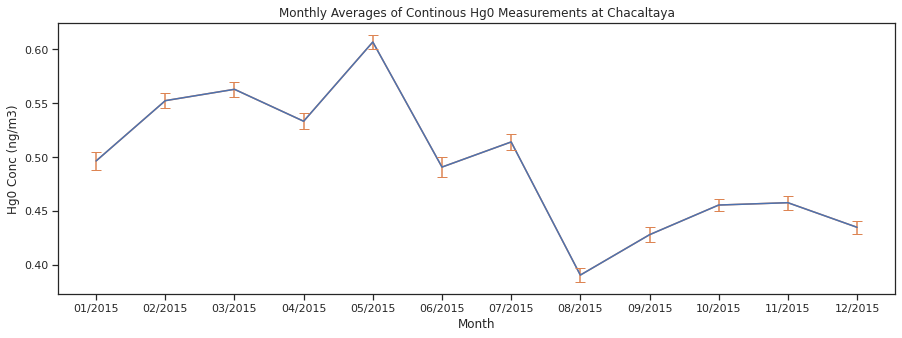

In [111]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)

#plotting, with error bars
ax.plot(months, Hg0concav['Concentration'])
# plt.errorbar(months, Hg0concav['Hg0conc'], yerr=stdHg0list, capsize=5.0, barsabove=True) #if you want to use standard deviation for error bars
plt.errorbar(months, Hg0concav['Concentration'], yerr=semHg0list, capsize=5.0, barsabove=True) #if you want to use standard error of mean for error bars
plt.title('Monthly Averages of Continous Hg0 Measurements at Chacaltaya')

'''showing all dates will make x axis unreadable. the following will only print every 5th date'''
every_nth = 1
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.xlabel('Month')
plt.ylabel('Hg0 Conc (ng/m3)')

In [93]:
CTC.describe()

,Concentration
count,24702.000000
mean,0.492177
std,0.324354
min,0.001000
25%,0.175000
50%,0.504000
75%,0.798000
max,0.999000


In [97]:
CTC=CTC.drop(['Date/time'], axis=1)

In [99]:
CTC['Month'] = CTC.index.month

In [100]:
CTC

,Concentration,Month
Date/time,,
2015-01-01 00:05:00,0.748,1
2015-01-01 00:20:00,0.864,1
2015-01-01 00:35:00,0.908,1
2015-01-01 01:20:01,0.304,1
2015-01-01 01:50:00,0.804,1
...,...,...
2015-12-31 22:45:01,0.806,12
2015-12-31 23:00:01,0.905,12
2015-12-31 23:15:01,0.819,12


<AxesSubplot:title={'center':'Concentration'}, xlabel='[Month]'>

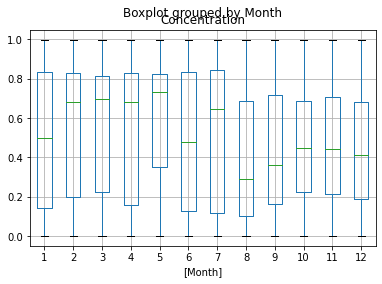

In [101]:
CTC.boxplot(column=['Concentration'], by=['Month'])

Text(0.5, 1.0, 'Concentration')

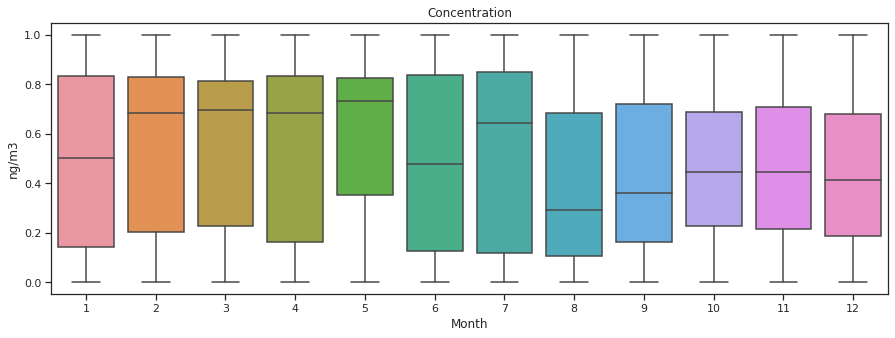

In [106]:
import seaborn as sns
sns.set_theme(style="ticks")
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
sns.boxplot(data=CTC, x='Month', y='Concentration', ax=ax)
ax.set_ylabel('ng/m3')
ax.set_title('Concentration')

In [107]:
CTC.describe()

,Concentration,Month
count,24702.000000,24702.000000
mean,0.492177,6.612218
std,0.324354,3.450885
min,0.001000,1.000000
25%,0.175000,4.000000
50%,0.504000,7.000000
75%,0.798000,10.000000
max,0.999000,12.000000


In [108]:
CTC['year'] = CTC.index.year

Text(0.5, 1.0, 'Concentration')

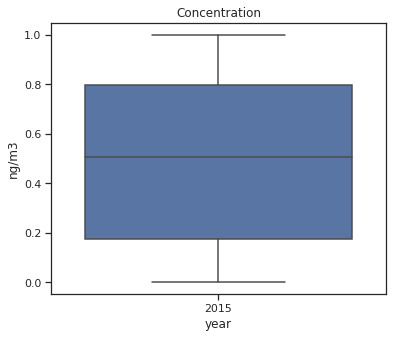

In [110]:
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
sns.boxplot(data=CTC, x='year', y='Concentration', ax=ax)
ax.set_ylabel('ng/m3')
ax.set_title('Concentration')

In [121]:
path ='/net/fs03/d1/tzd/2014/L1_TGM_CHC_2014.csv'
Bol14= pd.read_csv(path)
Bol14.head(50)

,MAGAND Olivier,DOMMERGUE Aurelien;
0,Institut des Geosciences de l'Environnement (I...,NaN
1,GOS4M international network (www.gos4m.org):;/,NaN
2,Matrix:;TGM,NaN
3,Instrument type: ;Ambient mercury vapour analy...,NaN
4,Laboratory:;Institut des Geosciences de l'Envi...,NaN
5,Instrument manufacturer: ;Tekran instrument co...,NaN
6,Instrument model: ;2357A (TGM or GEM),NaN
7,Instrument serial number: ;#238,NaN
8,Measurements startdate YYMM:;201407,NaN
9,Measurements time period YYMM:;201407-201412,NaN


In [126]:
Bol14 = Bol14.iloc[35:]
Bol14.reset_index(inplace= True, drop =True)
#rename columns
Bol14.columns =['Date/time','Concentration']
#drop NA files 
CTC14 = Bol14[Bol14['Concentration'].notna()]
#change concentrations to floating point
CTC14.reset_index(inplace= True, drop =True)
CTC14


,Date/time,Concentration
0,04/07/2014 05:40;0,762
1,04/07/2014 05:55;0,702
2,04/07/2014 06:10;0,971
3,04/07/2014 06:25;0,814
4,04/07/2014 06:40;1,007
...,...,...
14220,31/12/2014 22:05;0,767
14221,31/12/2014 22:20;1,017
14222,31/12/2014 22:50;0,796
14223,31/12/2014 23:05;0,796


In [127]:
conc =[]
date = []
for index, dat in enumerate(CTC14['Concentration']):
    conc.append(float(dat)/1000)
    ndate = CTC14['Date/time'][index][:-2]+':'+CTC14['Date/time'][index][-1]
    #CTC['Date/time'][index][-2]=':'
    #print(CTC['Date/time'][index][-2:])
    date.append(ndate)

CTC14['Date/time']=date
CTC14['Concentration'] = conc


CTC14['Date/time'] = pandas.to_datetime(CTC14['Date/time']) # Convert that column into a datetime datatype

CTC14.index = CTC14['Date/time'] # Set the datetime column as the index
CTC14

<ipython-input-127-556308ae0365>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CTC14['Date/time']=date
<ipython-input-127-556308ae0365>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CTC14['Concentration'] = conc
<ipython-input-127-556308ae0365>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

,Date/time,Concentration
Date/time,,
2014-04-07 05:40:00,2014-04-07 05:40:00,0.762
2014-04-07 05:55:00,2014-04-07 05:55:00,0.702
2014-04-07 06:10:00,2014-04-07 06:10:00,0.971
2014-04-07 06:25:00,2014-04-07 06:25:00,0.814
2014-04-07 06:40:01,2014-04-07 06:40:01,0.007
...,...,...
2014-12-31 22:05:00,2014-12-31 22:05:00,0.767
2014-12-31 22:20:01,2014-12-31 22:20:01,0.017
2014-12-31 22:50:00,2014-12-31 22:50:00,0.796


In [128]:
CTC14['Month'] = CTC14.index.month

<ipython-input-128-8714d421fa5a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CTC14['Month'] = CTC14.index.month


Text(0.5, 1.0, 'Concentration')

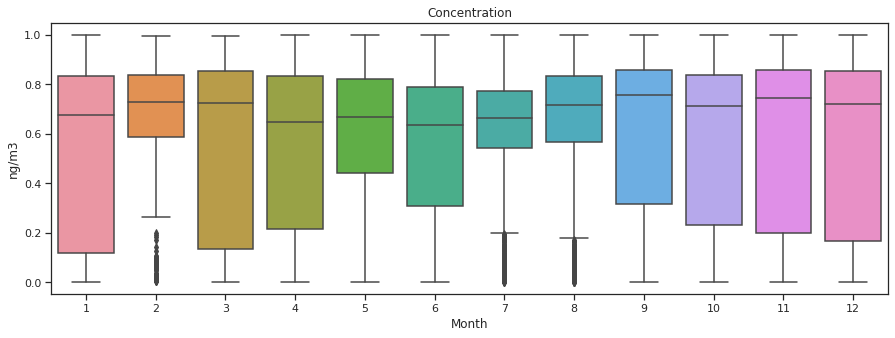

In [129]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
sns.boxplot(data=CTC14, x='Month', y='Concentration', ax=ax)
ax.set_ylabel('Hg0 ng/m3')
ax.set_title('Observed Hg0 Concentration')

In [130]:
CTC14.describe()

,Concentration,Month
count,14225.000000,14225.000000
mean,0.592072,8.424815
std,0.317932,2.705370
min,0.001000,1.000000
25%,0.288000,7.000000
50%,0.706000,9.000000
75%,0.836000,11.000000
max,0.999000,12.000000


In [132]:
date=[]
#df_dif will be a dataset that shows the differente between the ASGM and base cases
df_d=df_Bsurf['IJ-AVG-S_Hg0']
df_d=df_d.to_frame()
for row in df_d.itertuples():
    date.append(row.Index[3])
    #print(row.Index[3])
        
df_d['datetime'] = date # Create a column from the datetime variable

df_d['datetime'] = pandas.to_datetime(df_d['datetime']) # Convert that column into a datetime datatype

df_d.index = df_d['datetime'] # Set the datetime column as the index



In [140]:
df_d['Month'] = df_d.index.month

In [141]:
df_d

,IJ-AVG-S_Hg0,datetime,Month
datetime,,,
2015-01-01,0.296195,2015-01-01,1
2015-02-01,0.375870,2015-02-01,2
2015-03-01,0.543671,2015-03-01,3
2015-04-01,0.700514,2015-04-01,4
2015-05-01,0.807922,2015-05-01,5
...,...,...,...
2015-08-01,1.237127,2015-08-01,8
2015-09-01,1.185414,2015-09-01,9
2015-10-01,1.135955,2015-10-01,10


Text(0.5, 1.0, 'GEOS Chem Output Hg0 Concentrations ')

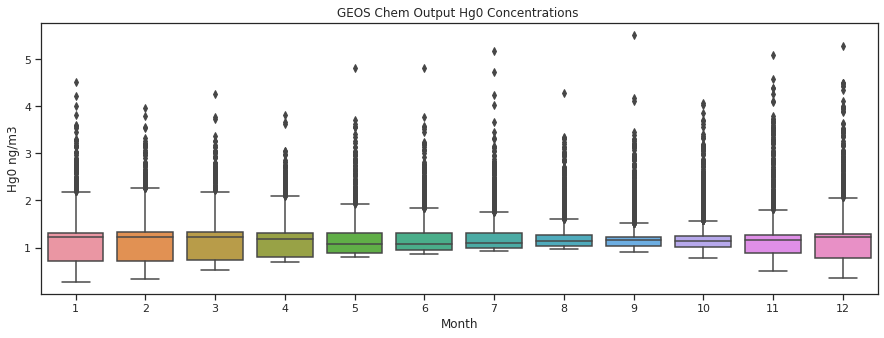

In [145]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
sns.boxplot(data=df_d, x='Month', y='IJ-AVG-S_Hg0', ax=ax)
#sns.boxplot(data=CTC14, x='Month', y='Concentration', ax=ax)
ax.set_ylabel('Hg0 ng/m3')
ax.set_title('GEOS Chem Output Hg0 Concentrations ')

In [133]:
# Group the data by month, and take the mean for each group (i.e. each month) ######DIFFERENCE########
Hg0concav=df_d.resample('M').mean()

# '''error bar information'''
#standard deviation calculated here
stdHg0=df_d['IJ-AVG-S_Hg0'].resample('M').std()
#calculate standard error of mean
semHg0=df_d['IJ-AVG-S_Hg0'].resample('M').sem()
#print(semHg0)

##making std and sem values into list
stdHg0list=[]
semHg0list=[]
for ind in range(len(stdHg0)):
    stdHg0list.append(stdHg0[ind])
    semHg0list.append(semHg0[ind])
Hg0concav 

,IJ-AVG-S_Hg0
datetime,
2015-01-31,1.042152
2015-02-28,1.048965
2015-03-31,1.060793
2015-04-30,1.080966
2015-05-31,1.099913
2015-06-30,1.136424
2015-07-31,1.163379
2015-08-31,1.165435
2015-09-30,1.153666


Text(0, 0.5, 'Hg0 Conc (ng/m3)')

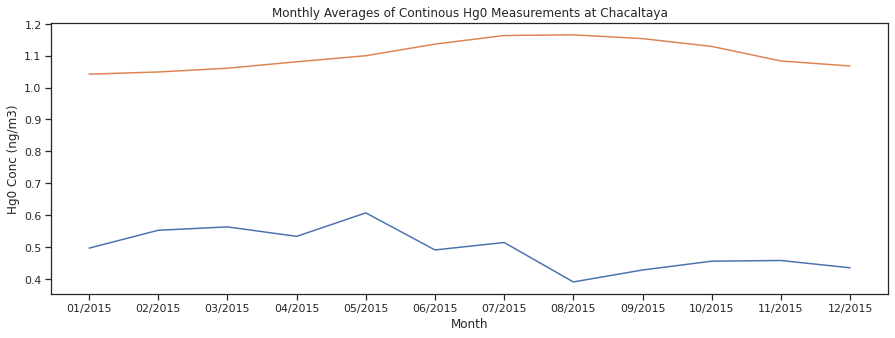

In [138]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)

#plotting, with error bars
ax.plot(months, Hg0concavCTC['Concentration'])
ax.plot(months, Hg0concav['IJ-AVG-S_Hg0'])

# plt.errorbar(months, Hg0concav['Hg0conc'], yerr=stdHg0list, capsize=5.0, barsabove=True) #if you want to use standard deviation for error bars
#plt.errorbar(months, Hg0concav['Concentration'], yerr=semHg0list, capsize=5.0, barsabove=True) #if you want to use standard error of mean for error bars
plt.title('Monthly Averages of Continous Hg0 Measurements at Chacaltaya')

'''showing all dates will make x axis unreadable. the following will only print every 5th date'''
every_nth = 1
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.xlabel('Month')
plt.ylabel('Hg0 Conc (ng/m3)')